# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и первичный анализ данных

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import display
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.dummy import DummyRegressor

from sklearn.metrics import (make_scorer\
                             , mean_squared_error)

In [120]:
df_autos = pd.read_csv("/datasets/autos.csv")
display(df_autos.head(5))
display(df_autos.describe())
df_autos.info()
display(df_autos.isnull().sum())

# Общий процент пропусков в выборке
gaps = df_autos.isnull().sum().sum()
print('Пропуски в исходной выборке, всего: ', gaps)
print()
print("Процент пропусков в столбцах %:") 
print(round(df_autos.isnull().sum() * 100 /(len(df_autos)), 2).sort_values(ascending=False, inplace=False).head(5))

<div class="alert alert-block alert-info">
<b>Вывод</b>

1. Фотографии автомобилей отсутствуют (NumberOfPictures = 0 для всех строк датасета)

2. У части датасета есть пропущенные значения 
- была машина в ремонте или нет (NotRepaired, 20% датасета)
- типа автомобильного кузова (VehicleType, 10,6% датасета)
- тип топлива (FuelType, 9,3% датасета)
- тип коробки передач (Gearbox, 5,6% датасета)
- модель автомобиля (Model, 5,6% датасета)
3. Встречается некорректно заполненные данные:
- цена (Price,	min = 0)
- год регистрации автомобиля (RegistrationYear, max = 9999, min =1000)
- мощность (Power, max = 20000, min = 0)
4. Все даты имеют тип "Object" (DateCrawled, DateCreated, LastSeen). Но эти не значимы для моделирования, их можно исключить.
</div>

In [121]:
#1. Поиск полных дубликатов
print("Число полных дубликатов строк в таблице:", df_autos.duplicated().sum())
df_autos = df_autos.drop_duplicates().reset_index(drop=True)
print("Число полных дубликатов строк в таблице после исключения:", df_autos.duplicated().sum())

In [122]:
#1. Проверим, есть ли проблемы с регистрами
cat = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand','NotRepaired']
print('Значения, принимаемые категориальными признаками с пропусками (',', '.join(cat),'):')
for i in cat:
    print()
    print(i)
    print(df_autos[i].value_counts()) 

<div class="alert alert-block alert-info">
<b>Вывод</b>

1. Полные дубликаты исключены
2. Проблем с регистрами не выявлено
</div>

In [123]:
models = df_autos['Model'].value_counts().to_frame()
df_models = pd.DataFrame(models)
df_models = df_models.reset_index()
df_models.columns = ['Model', 'ModelCount']
print(df_models[df_models['ModelCount']>10000])
print()

<div class="alert alert-block alert-info">
<b>Вывод</b>

Cуществуют довольно редкие модели автомобилей,   
вторая из наиболее популярных имеет наименование "other", незаполненные столбцы сможем отнести к этой категории.

Соответствие модели сериям не проверяю.
</div>

### Обработка данных

In [124]:
#1. Исключим столбец NumberOfPictures (нет данных)
df = df_autos.drop(['NumberOfPictures'], axis=1) 

#2. Исключим другие ненужные столбцы (даты, индекс)
df = df.drop(["DateCrawled", "DateCreated", "PostalCode", "LastSeen", 'RegistrationMonth'], axis=1) 

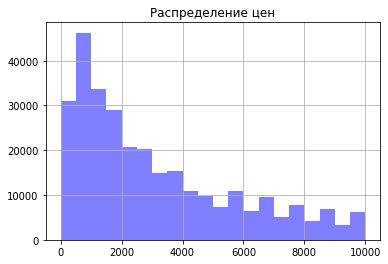

In [125]:
#3. Исключим/скорректируем нерелеавнтные строки
###Price, min = 0 или меньше $100
print('Цены не указана: ', df['Price'][df['Price']<100].count(), ' или ', round(df['Price'][df['Price']==0].count()/len(df) * 1000)/10, "% датасета")
df['Price'][(df['Price']>0)&(df['Price']<10000)].hist(bins=20, alpha = 0.5, color = 'b').set_title('Распределение цен')
plt.show()
#Исключим такие данные
df = df.query('Price >= 100')

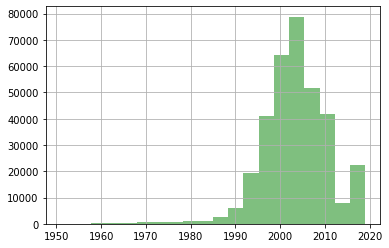

In [126]:
###RegistrationYear, max = 9999
print('Год регистрации не указан: ', df['RegistrationYear'][(df['RegistrationYear']>=2022)|(df['RegistrationYear']<1950)].count()\
      ,' или ', round(df['RegistrationYear'][(df['RegistrationYear']>=2022)|(df['RegistrationYear']<1950)].count()/len(df) * 1000)/10, "% датасета")
#Исключим эти данные
df = df[(df['RegistrationYear']<2022)&(df['RegistrationYear']>1950)]
df['RegistrationYear'].hist(bins=20, alpha = 0.5, color = 'g')
plt.show()

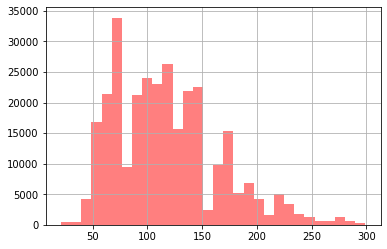

In [127]:
###Power, max = 20000, min = 0
print('Мощность двигателя указана некорректно: ', df['Power'][(df['Power']>600)|(df['Power']<20)].count()\
      ,' или ', round(df['Power'][(df['Power']>600)|(df['Power']<20)].count()/len(df) * 1000)/10, '% датасета')
df['Power'][(df['Power']<300)&(df['Power']>20)].hist(bins=30, alpha = 0.5, color = 'r')
plt.show()
###Допустим, что минимальная возможная можность - 20, максимальная - 600
df = df[(df['Power']<= 600)&(df['Power']>=20)]

In [128]:
#4. Дозаполним пропущенные значения
display(df.isnull().sum())

In [129]:
#4.1 NotRepaired, 46113 (после изменений)
print('-------------------------------')
print('Число непустых значений NotRepaired: ')
print(df['NotRepaired'].value_counts())
#Считаем, что если не заполнена, то не ремонтировалась
df['NotRepaired'] = df['NotRepaired'].fillna('no')
print('Число непустых значений NotRepaired после изменения: ')
print(df['NotRepaired'].value_counts())

In [130]:
#4.2 FuelType, 19276
print('-------------------------------')
print('Число непустых значений FuelType: ')
print(df['FuelType'].value_counts())
#Заметим, что бензин назван по-разному - petrol и gasoline. Переименуем все в petrol
#Незаполненные также заполним значением petrol
df.loc[df['FuelType'] == 'gasoline','FuelType'] = 'petrol'

df['FuelType'] = df['FuelType'].fillna('petrol')
print('Число непустых значений FuelType после изменения: ')
print(df['FuelType'].value_counts())

In [131]:
#4.3 Model, 11981
print('-------------------------------')
print('Число непустых значений Model: ')
print(df['Model'].value_counts().head())
df['Model']= df['Model'].fillna('other')
print('Число непустых значений Model после изменения: ')
print(df['Model'].value_counts().head())

In [132]:
#4.4 VehicleType, 20870
print('-------------------------------')
print('Число непустых значений VehicleType: ')
print(df['VehicleType'].value_counts())

In [133]:
# Найдем самые популярные типы кузова у конкретных марок и моделей автомобилей
#df['VehicleType'] =  df['VehicleType'].fillna('Unknown')
#vehicle_dict = df.groupby(['Brand','Model'])['VehicleType'].agg(lambda x: x.value_counts(sort=True, ascending=False).index[0])
#vehicle_dict = vehicle_dict.reset_index()
#print(vehicle_dict.head())
#Заменим Unknown получившимися в справочнике значениями
#df_n = df.merge(vehicle_dict, on=['Brand','Model'], how='left')
#df_n.loc[(df_n['VehicleType_x'] == 'Unknown'),'VehicleType_x'] = df_n['VehicleType_y']
#df_n = df_n.drop(['VehicleType_y'], axis=1)
#df_n = df_n.rename(columns= {'VehicleType_x': 'VehicleType'})
#print(df_n.head())

print('Число непустых значений VehicleType после изменения: ')
print(df_n['VehicleType'].value_counts().head())

<div class="alert alert-block alert-info">

<b>Полезная ссылка: </b> https://stackoverflow.com/questions/59127458/pandas-fillna-using-groupby-and-mode
</div>

In [134]:
#4.5 Gearbox, 5819
print('-------------------------------')
print('Число непустых значений Gearbox: ')
print(df_n['Gearbox'].value_counts())
df_n =  df_n.dropna(subset=['Gearbox'])

In [135]:
display(df_n.isnull().sum())

### Распределения признаков. Оценка значений и корреляций.

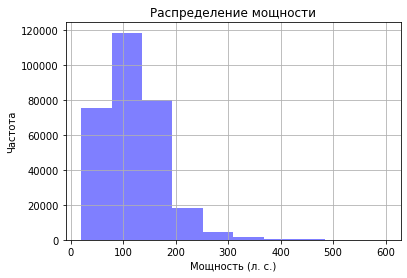

In [136]:
df_n['Power'].hist(bins = 10, alpha = 0.5, color = 'b')
plt.xlabel('Мощность (л. с.)')
plt.ylabel('Частота')
plt.title('Распределение мощности');
plt.show()

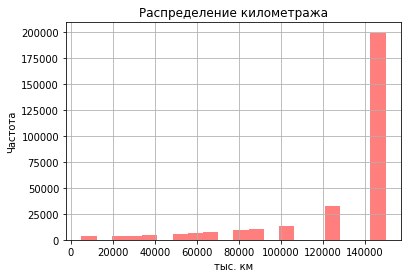

In [137]:
df_n['Kilometer'].hist(bins = 20, alpha = 0.5, color = 'r')
plt.xlabel('тыс. км')
plt.ylabel('Частота')
plt.title('Распределение километража');
plt.show()

print('Машин с пробегом от 140 тыс. км до 160 тыс. км: ', df_n['Kilometer'][(df_n['Kilometer']>= 140000)&(df_n['Kilometer']<=160000)].count()\
      ,' или ', round(df_n['Kilometer'][(df_n['Kilometer']>= 140000)&(df_n['Kilometer']<=160000)].count()/len(df_n) * 1000)/10, '% датасета')


<div class="alert alert-block alert-info">
<b>Вывод</b>

Более 60% машин имеет пробег от 140 тыс. км до 160 тыс. км
Среднестатистический автомобиль проезжает около 15 тыс. км в год. Т.е. большинству автомобилей в дата сете около 10 лет.
</div>

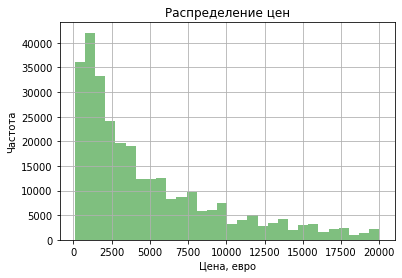

In [138]:
df_n['Price'].hist(bins = 30, alpha = 0.5, color = 'g')
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.title('Распределение цен');
plt.show()

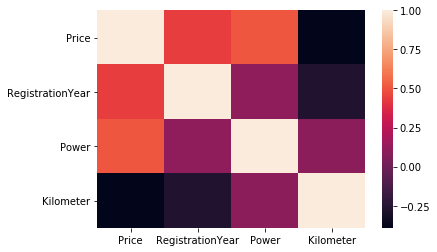

In [139]:
sns.heatmap(df_n.corr())
corr = df_n.corr()

print('Корреляция между ценой и годом регистрации', corr['Price']['RegistrationYear'])
print('Корреляция между ценой и мощностью', corr['Price']['Power'])
print('Корреляция между ценой и мощностью', corr['Price']['Kilometer'])

<div class="alert alert-block alert-info">
<b>Вывод</b>

Цена сильно коррелируем с мощностью и годом регистрации автомобиля.
Цена имеет отрицательную корреляцию с пробегом.
</div>

## Обучение моделей

### Подготовка признаков

Выделим и подготовим признаки для обучения моделей.

#### Разделение на целевой и признаки для обучения

In [142]:
target=df_n['Price'] #Целевой признак

features = df_n.drop('Price', axis=1)

print('Проверим размеры выборок:')
print('Target ', target.shape)

#### Метод One-Hot Encoding

In [143]:
#2.1 Создадим признаки, созданные по методу прямого кодирования с защитой от дамми-ловушки.
#(Преобразуем категориальные признаки в численные техникой прямого кодирования (OHE))
features_ohe = pd.get_dummies(features, drop_first=True)

display(features.head())
features.info()

<div class="alert alert-block alert-info">
<b>Вывод</b>

Техника прямого кодирования (OHE) добавила сотни новых признаков, что может негативно сказаться на производительности.
</div>

#### Метод Ordinal Encoding c One-Hot Encoding признаками для категориальных признаков с малым числом категорий

Преобразуем категориальные признаки в численные техникой порядкового кодирования - Ordinal Encoding

In [144]:
#(!)Часть признаков закодируем OHE (где небольшое число категорий)
features_oe = pd.get_dummies(features, columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], drop_first=True)
features_oe.head()
# Преобразуем категориальные признаки в численные техникой порядкового кодирования - Ordinal Encoding
encoder = OrdinalEncoder()                          # создаем объект структуры данных OrdinalEncoder
encoder.fit(features_oe)                                   # получаем список категориальных признаков
features_oe = pd.DataFrame(encoder.transform(features_oe),       # преобразуем данные, добавляем названия столбцов 
                         columns=features_oe.columns)

print(features_oe.info())
print("Размер данных после преобразования Ordinal Encoder:", df_oe.shape)
display(features_oe.head())

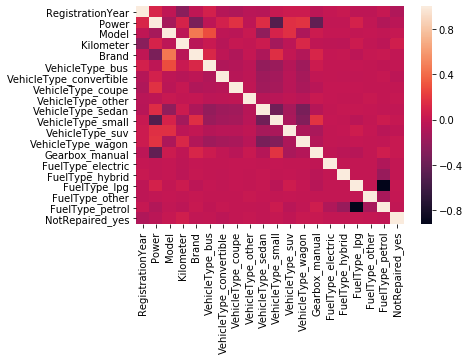

In [146]:
sns.heatmap(features_oe.corr())
plt.show()
corr = features_oe.corr()

print('Корреляция между брендом и моделью', corr['Brand']['Model'])

<div class="alert alert-block alert-info">
<b>Вывод</b>

Есть корреляция между брендом и моделью.
</div>

#### Масштабирование количественных признаков

In [147]:
numeric1 = ['RegistrationYear', 'Power', 'Kilometer']

In [148]:
# Игнорируем предупреждение при записи изменённых признаков в исходный датафрейм
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric1]) 
features[numeric1] = scaler.transform(features[numeric1])

#1) OHE (305 признаков). Масштабируем только числовые переменные, категориальные не масштабируем
scaler_ohe = StandardScaler()
scaler_ohe.fit(features_ohe[numeric1]) #для числовых переменных (numeric)
features_ohe[numeric1] = scaler_ohe.transform(features_ohe[numeric1])

#2) OE+OHE (20 признаков). Масштабируем все признаки
scaler_oe = StandardScaler()
scaler_oe.fit(features_oe_train) #для всех
features_oe = pd.DataFrame(scaler_oe.transform(features_oe), columns = features_oe.columns)

#3) OE+OHE (305 признаков). Масштабируем все признаки (для LinearRegression)
scaler_ohe_sc = StandardScaler()
scaler_ohe_sc.fit(features_ohe) 
features_ohe_sc = pd.DataFrame(scaler_ohe_sc.transform(features_ohe), columns = features_ohe.columns)

#scaler_ohe_sc.fit(features_ohe_test) 
#features_ohe_test_sc  = pd.DataFrame(scaler_ohe_sc.transform(features_ohe_test),  columns = features_ohe_train.columns)

print('------------------')
print('Features')
display(features.head())
features_train.info()

print('------------------')
print('Features_ohe')
display(features_ohe.head())
features_ohe_train.info()

print('------------------')
print('Features_oe_масшатибированный полностью (для линейной регрессии)')
display(features_oe.head())
features_oe.info()

print('------------------')
print('Features_ohe_sc_масшатибированный полностью (для linear)')
display(features_ohe_sc.head())
features_ohe_sc.info()

#### Разделение на обучающую и тестовую выборки

In [154]:
# Выделим 80% данных для обучаюшей выборки и 20% данных для проверки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=12345)

features_oe_train, features_oe_test, target_oe_train, target_oe_test = train_test_split(
    features_oe, target, test_size=0.2, random_state=12345)

features_ohe_train_sc, features_ohe_test_sc, target_ohe_train_sc, target_ohe_test_sc = train_test_split(
    features_ohe_sc, target, test_size=0.2, random_state=12345)

print('Target_train ', target_train.shape)
print('Features_train ', features_train.shape)

print('Target_test ', target_test.shape)
print('Features_test ', features_test.shape)

## Анализ моделей

**Будем рассмотривать следующие модели:**
1. Linear regression / Модель линейной регрессии
2. Decision Tree regression / Модель дерева решений
3. Random Forest regression / Модель случайного леса
4. Categorical Boosting (CatBoost)
5. Light Gradient Boosting Machine (LightGBM)
6. XGBoost
7. Dummy regression / Константная модель

In [150]:
#расчет RMSE
def rmse(validation, predictions):
    return mean_squared_error(validation, predictions) ** 0.5

### Linear regression / Модель линейной регрессии

#### Для One-Hot Encoding признаков (305 признаков)

In [155]:
#Ordinal Encoding+OHE c маштабированными признаками
model_linear = LinearRegression()

start = time.time()
model_linear.fit(features_ohe_train_sc, target_ohe_train) #все признаки были масштабированы (числовые и категориальные)
end = time.time()

linear_fit = end - start
print('Время обучение линейной регрессии в секундах: {:.2f}'.format(linear_fit))

In [156]:
start = time.time()
predicted_ohe_test_sc = model_linear.predict(features_ohe_test_sc)
end = time.time()

linear_prediction = end - start
print('Время предсказания линейной регрессии в секундах: {:.2f}'.format(linear_prediction))

In [159]:
rmse_linear = rmse(predicted_ohe_test_sc, target_ohe_test_sc)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_linear))

#### Для Ordinar encoding c One-Hot Encoding признаками (20 признаков)

In [162]:
#Ordinal Encoding+OHE c маштабированными признаками
model_linear = LinearRegression()

start = time.time()
model_linear.fit(features_oe_train, target_oe_train) #все признаки были масштабированы (числовые и категориальные)
end = time.time()

linear_fit_oe = end - start
print('Время обучение линейной регрессии в секундах: {:.2f}'.format(linear_fit))

In [163]:
start = time.time()
predicted_oe_test = model_linear.predict(features_oe_test)
end = time.time()

linear_prediction_oe = end - start
print('Время предсказания линейной регрессии в секундах: {:.2f}'.format(linear_prediction))

In [164]:
rmse_linear_oe = rmse(predicted_oe_test, target_oe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_linear))

In [1]:
#Можно еще добавить кросс-валидацию и посмотрать Feature importance

<div class="alert alert-block alert-info">
<b>Вывод</b>

Линейная регрессия работает одинаково как на моделе с 305 признаками (OHE), так и на моделе с 20 признаками (OE+OHE). 
Выигрыша по времени или точности нет.
</div>

### Decision Tree regression / Модель дерева решений

#### Для One-Hot Encoding признаков (305 признаков)

In [173]:
model_tree = DecisionTreeRegressor()

# Подбираем гиперпараметры модели дерева решений
tree_params = {'max_depth': range(7, 21, 6), 'max_features': range(10,30,6)\
               , 'min_samples_leaf' : [6, 10, 21],'random_state': [12345]}

scorer = make_scorer(rmse, greater_is_better = False)

# Тренируем перебором вариантов
start = time.time()
grid_search_tree = GridSearchCV(model_tree, param_grid=tree_params, scoring=scorer, cv=5)
grid_search_tree.fit(features_ohe_train, target_ohe_train)
end = time.time()

tree_grid = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(tree_grid))
print('Подобраны гиперпараметры модели дерева решений: ', grid_search_tree.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_tree.best_score_)))

In [174]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
model_tree = DecisionTreeRegressor(max_depth = 19, max_features = 28, min_samples_leaf = 10, random_state = 12345)
start = time.time()
model_tree.fit(features_ohe_train, target_ohe_train)
end = time.time()

tree_fit = end - start
print('Время обучение дерева решений с оптимальными параметрами в секундах: {:.2f}'.format(tree_fit))

In [175]:
start = time.time()
predicted_ohe_test = model_tree.predict(features_ohe_test)
end = time.time()

tree_prediction = end - start
print('Время предсказания линейной регрессии в секундах: {:.2f}'.format(tree_prediction))

In [176]:
rmse_tree = rmse(predicted_ohe_test, target_ohe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_tree))

In [177]:
tree_features_importanse = pd.Series(model_tree.feature_importances_, index=features_ohe_train.columns)
tree_features_importanse = tree_features_importanse / tree_features_importanse.sum()

#### Для Ordinar encoding c One-Hot Encoding признаками (20 признаков)

In [178]:
model_tree = DecisionTreeRegressor()

# Подбираем гиперпараметры модели дерева решений
tree_params = {'max_depth': range(7, 21, 6), 'max_features': range(10, 20, 6)\
               , 'min_samples_leaf' : [6, 10, 21],'random_state': [12345]}

scorer = make_scorer(rmse, greater_is_better = False)

# Тренируем перебором вариантов
start = time.time()
grid_search_tree_oe = GridSearchCV(model_tree, param_grid=tree_params, scoring=scorer, cv=5)
grid_search_tree_oe.fit(features_oe_train, target_oe_train)
end = time.time()

tree_grid_oe = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(tree_grid_oe))
print('Подобраны гиперпараметры модели дерева решений: ', grid_search_tree_oe.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_tree_oe.best_score_)))

In [179]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
model_tree_oe = DecisionTreeRegressor(max_depth = 19, max_features = 16, min_samples_leaf = 6, random_state = 12345)
start = time.time()
model_tree_oe.fit(features_oe_train, target_oe_train)
end = time.time()

tree_fit_oe = end - start
print('Время обучение дерева решений с оптимальными параметрами в секундах: {:.2f}'.format(tree_fit_oe))

In [180]:
start = time.time()
predicted_oe_test = model_tree_oe.predict(features_oe_test)
end = time.time()

tree_prediction_oe = end - start
print('Время предсказания линейной регрессии в секундах: {:.2f}'.format(tree_prediction_oe))

In [181]:
rmse_tree_oe = rmse(predicted_oe_test, target_oe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_tree_oe))

In [182]:
tree_features_importanse_oe = pd.Series(model_tree_oe.feature_importances_, index=features_oe_train.columns)
tree_features_importanse_oe = tree_features_importanse_oe / tree_features_importanse_oe.sum()

### Random Forest regression / Модель случайного леса

#### Для One-Hot Encoding признаков (305 признаков)

In [183]:
model_forest = RandomForestRegressor()
forest_params = {'max_depth': range(7, 21, 6), 'max_features': range(10,30,6)\
                 , 'n_estimators': range (14, 34, 10),'random_state': [12345]}

# Тренируем модель перебором вариантов
scorer = make_scorer(rmse, greater_is_better = False)
grid_search_forest = GridSearchCV(model_forest, param_grid=forest_params, scoring = scorer, cv=5)
# Подбираем гиперпараметры
start = time.time()
grid_search_forest.fit(features_ohe_train, target_ohe_train)
end = time.time()

forest_grid = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(forest_grid))
print('Подобраны гиперпараметры модели дерева решений: ', grid_search_forest.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_forest.best_score_)))

In [184]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
model_forest = RandomForestRegressor(max_depth = 19, max_features = 28, n_estimators = 24, random_state = 12345)
start = time.time()
model_forest.fit(features_ohe_train, target_ohe_train)
end = time.time()

forest_fit = end - start
print('Время обучение дерева решений с оптимальными параметрами в секундах: {:.2f}'.format(forest_fit))

In [188]:
start = time.time()
predicted_ohe_test = model_forest.predict(features_ohe_test)
end = time.time()

forest_prediction = end - start
print('Время предсказания дерева решений в секундах: {:.2f}'.format(forest_prediction))

In [189]:
rmse_forest = rmse(predicted_ohe_test, target_ohe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_forest))

In [190]:
forest_features_importanse = pd.Series(model_forest.feature_importances_, index = features_ohe_train.columns)
forest_features_importanse = forest_features_importanse / forest_features_importanse.sum()

#### Для Ordinal Encoding признаков c One-Hot Encoding признаками (20 признаков)

In [191]:
model_forest = RandomForestRegressor()
forest_params = {'max_depth': range(7, 21, 6), 'max_features': range(10, 20, 6)\
                 , 'n_estimators': range (14, 34, 10),'random_state': [12345]}

# Тренируем модель перебором вариантов
scorer = make_scorer(rmse, greater_is_better = False)
grid_search_forest = GridSearchCV(model_forest, param_grid=forest_params, scoring = scorer, cv=5)
# Подбираем гиперпараметры
start = time.time()
grid_search_forest.fit(features_oe_train, target_oe_train)
end = time.time()

forest_grid_oe = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(forest_grid_oe))
print('Подобраны гиперпараметры модели дерева решений: ', grid_search_forest.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_forest.best_score_)))

In [192]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
model_forest_oe = RandomForestRegressor(max_depth = 19, max_features = 10, n_estimators = 24, random_state = 12345)
start = time.time()
model_forest_oe.fit(features_oe_train, target_oe_train)
end = time.time()

forest_fit_oe = end - start
print('Время обучение дерева решений с оптимальными параметрами в секундах: {:.2f}'.format(forest_fit_oe))

In [193]:
start = time.time()
predicted_oe_test = model_forest_oe.predict(features_oe_test)
end = time.time()

forest_prediction_oe = end - start
print('Время предсказания дерева решений в секундах: {:.2f}'.format(forest_prediction_oe))

In [194]:
rmse_forest_oe = rmse(predicted_oe_test, target_oe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_forest_oe))

In [195]:
forest_features_importanse_oe = pd.Series(model_forest_oe.feature_importances_, index = features_oe_train.columns)
forest_features_importanse_oe = forest_features_importanse_oe / forest_features_importanse_oe.sum()

### Categorical Boosting (CatBoost)

#### На исходных признаках

In [196]:
cat_features = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']

model_cat = CatBoostRegressor()    

# Подбираем гиперпараметры модели CatBoost
cat_params = {'learning_rate': [0.2], 'depth': [6, 10], 'iterations' : [60]}

# Тренируем модель перебором вариантов
scorer = make_scorer(rmse, greater_is_better = False)
    
# Тренируем модель CatBoost перебором вариантов
start = time.time()
grid_search_cat = GridSearchCV(model_cat, param_grid=cat_params, scoring = scorer, cv=5)
grid_search_cat.fit(features_train, target_train, cat_features=cat_features, verbose=50) 
end = time.time()

cat_grid = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(cat_grid))
print('Подобраны гиперпараметры модели Categorical Boosting: ', grid_search_cat.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_cat.best_score_)))

In [197]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
cat_features = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']
model_cat = CatBoostRegressor(learning_rate=0.2, iterations=60, depth=10, random_seed=12345) 
start = time.time()
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=50)
end = time.time()

cat_fit = end - start
print('Время обучение Categorical Boosting с оптимальными параметрами в секундах: {:.2f}'.format(cat_fit))

In [198]:
start = time.time()
predicted_test = model_cat.predict(features_test)
end = time.time()

cat_prediction = end - start
print('Время предсказания Categorical Boosting в секундах: {:.2f}'.format(cat_prediction))

In [199]:
rmse_cat = rmse(predicted_test, target_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_cat))

In [200]:
cat_features_importanse = pd.Series(model_cat.feature_importances_, index = features_train.columns)
cat_features_importanse = cat_features_importanse / cat_features_importanse.sum()

### Light Gradient Boosting Machine 

In [202]:
model_lgbm = LGBMRegressor()

lgbm_params = {'max_depth': [6,10], 'learning_rate': [0.02]\
               , 'num_leaves': [10, 20, 30]}

# Тренируем модель перебором вариантов
scorer = make_scorer(rmse, greater_is_better = False)
    
# Тренируем модель CatBoost перебором вариантов
start = time.time()
grid_search_lgbm = GridSearchCV(model_lgbm, param_grid = lgbm_params, scoring = scorer, cv=5)
grid_search_lgbm.fit(features_oe_train, target_oe_train) 
end = time.time()

lgbm_grid_oe = end - start

print('Время подбора параметров в секундах: {:.2f}'.format(lgbm_grid_oe))
print('Подобраны гиперпараметры модели дерева решений: ', grid_search_lgbm.best_params_)
print('Лучший score (RMSE): {:.2f}'.format(abs(grid_search_lgbm.best_score_)))

In [203]:
# Тестируем модель дерева решений с найденными оптимальными гиперпараметрами
model_lgbm = LGBMRegressor(max_depth=10, learning_rate = 0.02, num_leaves = 30, random_seed=12345)
start = time.time()
model_lgbm.fit(features_oe_train, target_oe_train)
end = time.time()

lgbm_fit_oe = end - start
print('Время обучение Light Gradient Boosting Machine с оптимальными параметрами в секундах: {:.2f}'.format(lgbm_fit_oe))

In [228]:
start = time.time()
predicted_test = model_lgbm.predict(features_oe_test)
end = time.time()

lgbm_prediction_oe = end - start
print('Время предсказания Light Gradient Boosting Machine в секундах: {:.2f}'.format(lgbm_prediction))

In [229]:
rmse_lgbm = rmse(predicted_oe_test, target_oe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_lgbm))

In [230]:
lgbm_features_importanse = pd.Series(model_lgbm.feature_importances_, index = features_oe_train.columns)
lgbm_features_importanse = lgbm_features_importanse / lgbm_features_importanse.sum()

<div class="alert alert-block alert-info">
<b>Можно использовать: </b> У lightGBM тоже есть внутренний метод кодировки. Для этого достаточно изменить тип колонок с категориальными признаками на соответствующий: .astype('category').
</div>

### Dummy regression / Константная модель

In [231]:
model_dummy = DummyRegressor(strategy = 'median')

start = time.time()
model_dummy.fit(features_ohe_train, target_ohe_train)
end = time.time()

dummy_fit = end - start
print('Время обучение dummy модели в секундах: {:.2f}'.format(dummy_fit))

In [232]:
start = time.time()
predicted_ohe_test = model_dummy.predict(features_ohe_test)
end = time.time()

dummy_prediction = end - start
print('Время предсказания dummy модели в секундах: {:.2f}'.format(dummy_prediction))

In [233]:
rmse_dummy = rmse(predicted_ohe_test, target_ohe_test)
print('Среднеквадратическая ошибка (RMSE): {:.2f}'.format(rmse_dummy))

### Сравнение моделей

In [234]:
#Модели
    #1 Linear regression / Модель линейной регрессии
    #2.1 Decision Tree regression / Модель дерева решений, One-Hot Encoding
    #2.2 Decision Tree regression / Модель дерева решений, Ordinal Encoding
    #3 Random Forest regression / Модель случайного леса
    #4 Categorical Boosting (CatBoost)
    #5 Light Gradient Boosting Machine (LightGBM)
    #6 Dummy regression / Константная модель
#Время:
#- поиск параметров
    #1 -
    #2.1 tree_grid
    #2.2 tree_grid_oe
#- время обучения
    #1 linear_fit
    #2.1 tree_fit
    #2.2 tree_fit_oe
#- время выполнения
    #1 linear_prediction
    #2.1 tree_prediction
    #2.2 tree_prediction_oe
#Общее время всекундах
    #1 linear_
    #2.1 tree_
    #2.2 tree_oe_
#RMSE тестовой выборки
    #1 rmse_linear
    #2.1 rmse_tree
    #2.2 rmse_tree_oe
    #3.1
    #3.3
index_res = ['1 Linear','2.1 Decision Tree, OHE', '2.2 Decision Tree, OE'\
             , '3.1 Random Forest OHE','3.2 Random Forest OE', '4 CatBoost'\
             , '5 LightGBM', '6 Dummy']

column_res = { 'Время подбора параметров в секундах' : [0, tree_grid, tree_grid_oe\
                                                        , forest_grid, forest_grid_oe, cat_grid\
                                                        , lgbm_grid_oe, 0],
              'Время обучения модели в секундах' : [linear_fit, tree_fit, tree_fit_oe\
                                                        , forest_fit, forest_fit_oe, cat_fit\
                                                        , lgbm_fit_oe, dummy_fit],
              'Скорость предсказания в секундах' : [linear_prediction, tree_prediction, tree_prediction_oe\
                                                        , forest_prediction, forest_prediction_oe, cat_prediction\
                                                        , lgbm_prediction_oe, dummy_prediction],
              'Среднеквадратическая ошибка (RMSE)' : [rmse_linear, rmse_tree, rmse_tree_oe\
                                                        , rmse_forest, rmse_forest_oe, rmse_cat\
                                                        , rmse_lgbm, rmse_dummy]}
res = pd.DataFrame(data = column_res, index = index_res)

display(res.loc[index_res])

<div class="alert alert-block alert-info">
<b>Вывод</b>

Получили результаты тестирования моделей:

1. Лучшее качество дает модель: Random Forest, LightGBM с выбранными параметрами.
2. Среднее качество при быстрой скорости обучения показывает модель Decision Tree на датафрейме с обработкой признаков Ordinal Encoding. 
</div>

### Дополнительно. Визуализация важности признаков для разных моделей

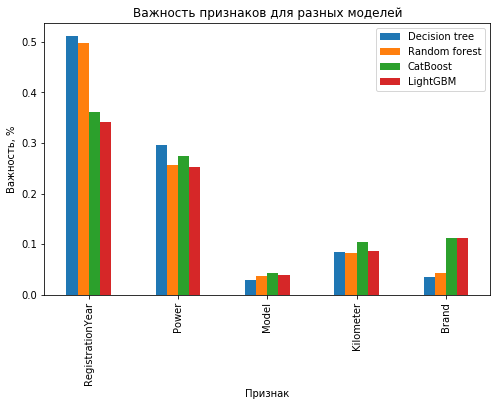

In [248]:
# Визуализация важности признаков для разных моделей
col = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']
features_imp = pd.DataFrame({'Decision tree' : tree_features_importanse_oe\
                             ,'Random forest' : forest_features_importanse_oe\
                             ,'CatBoost' : cat_features_importanse\
                             ,'LightGBM' : lgbm_features_importanse 
                            }, 
                            index = col)
fig, ax = plt.subplots(figsize=(8,5))
ax = features_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков для разных моделей")
ax.set_xlabel('Признак')
ax.set_ylabel('Важность, %')
plt.show()

display(features_imp)

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей